SIMPLE KNAPSACK

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2
import numpy as np
from PIL import Image
%matplotlib inline

GENERATING DATA

In [2]:
def test_knapsack(x_weights, x_prices, x_capacity, picks):
    total_price = np.dot(x_prices, picks)
    total_weight = np.dot(x_weights, picks)
    return total_price, max(total_weight - x_capacity, 0)


def brute_force_knapsack(x_weights, x_prices, x_capacity):
    picks_space = 2 ** x_weights.shape[0]
    best_price = 0
    best_picks = None
    for p in range(picks_space):
        picks = np.zeros((x_weights.shape[0]))
        for i, c in enumerate("{0:b}".format(p)[::-1]):
            picks[i] = c
        price, violation = test_knapsack(x_weights, x_prices, x_capacity, picks)
        if violation == 0:
            if price > best_price:
                best_price = price
                best_picks = picks
    return best_price, best_picks

def create_knapsack(item_count=5):
    x_weights = np.random.randint(1, 15, item_count)
    x_prices = np.random.randint(1, 10, item_count)
    x_capacity = np.random.randint(15, 50)
    _, y_best_picks = brute_force_knapsack(x_weights, x_prices, x_capacity)
    return x_weights, x_prices, x_capacity, y_best_picks

In [3]:
x_weights, x_prices, x_capacity, y_best_picks = create_knapsack()
print("Weights:", x_weights)
print("Prices:", x_prices)
print("Capacity:", x_capacity)
print("Best picks:", y_best_picks)

Weights: [10  4 10 13  5]
Prices: [6 8 8 4 4]
Capacity: 30
Best picks: [1. 1. 1. 0. 1.]


In [4]:
def metric_overprice(input_prices):
    def overpricing(y_true, y_pred):
        y_pred = K.round(y_pred)
        return K.mean(K.batch_dot(y_pred, input_prices, 1) - K.batch_dot(y_true, input_prices, 1))

    return overpricing

In [5]:
def metric_space_violation(input_weights, input_capacity):
    def space_violation(y_true, y_pred):
        y_pred = K.round(y_pred)
        return K.mean(K.maximum(K.batch_dot(y_pred, input_weights, 1) - input_capacity, 0))

    return space_violation

In [6]:
def metric_pick_count():
    def pick_count(y_true, y_pred):
        y_pred = K.round(y_pred)
        return K.mean(K.sum(y_pred, -1) - K.sum(y_true, -1))

    return pick_count

In [7]:
def create_knapsack_dataset(count, item_count=5):
    x = [[], [], []]
    y = [[]]
    for _ in range(count):
        p = create_knapsack(item_count)
        x[0].append(p[0])
        x[1].append(p[1])
        x[2].append([p[2],0,0,0,0])
        y[0].append(p[3])
    return x, y
train_x, train_y = create_knapsack_dataset(10000)
test_x, test_y = create_knapsack_dataset(200)

DATA PREPARATION

In [8]:
train_x_weights = pd.DataFrame()
for w in range(len(train_x[0])):
    train_x_weights = pd.concat( [train_x_weights, pd.DataFrame({"weights": [train_x[0][w]]})], ignore_index=True )


train_x_prices = pd.DataFrame()
for p in range(len(train_x[0])):
    train_x_prices = pd.concat( [train_x_prices, pd.DataFrame({"prices": [train_x[1][p]]})], ignore_index=True )

train_x_capacity = pd.DataFrame()
for c in range(len(train_x[2])):
    train_x_capacity = pd.concat( [train_x_capacity, pd.DataFrame({"capacity": [train_x[2][c]]})], ignore_index=True )

train_x_formatted = pd.concat([train_x_weights, train_x_prices, train_x_capacity], axis = 1, ignore_index=True)

train_y_formatted = pd.DataFrame()
for pick in range(len(train_y[0])):
    train_y_formatted = pd.concat( [train_y_formatted, pd.DataFrame({"picks": [train_y[0][pick]]})], ignore_index=True )
    

In [9]:
train_x_formatted.columns = ["prices", "weights", "capacities"]
train_x_formatted

,prices,weights,capacities
0,"[9, 5, 12, 2, 8]","[5, 3, 9, 9, 9]","[34, 0, 0, 0, 0]"
1,"[5, 11, 10, 4, 11]","[8, 7, 5, 2, 6]","[46, 0, 0, 0, 0]"
2,"[9, 4, 11, 2, 6]","[2, 5, 1, 4, 7]","[31, 0, 0, 0, 0]"
3,"[12, 12, 4, 13, 6]","[8, 7, 1, 9, 3]","[15, 0, 0, 0, 0]"
4,"[4, 5, 3, 2, 14]","[2, 9, 4, 4, 7]","[18, 0, 0, 0, 0]"
...,...,...,...
9995,"[13, 12, 6, 5, 5]","[1, 8, 1, 3, 6]","[43, 0, 0, 0, 0]"
9996,"[10, 6, 6, 2, 3]","[1, 5, 8, 9, 7]","[29, 0, 0, 0, 0]"
9997,"[14, 2, 13, 5, 10]","[8, 4, 8, 3, 1]","[21, 0, 0, 0, 0]"
9998,"[4, 12, 6, 10, 12]","[6, 6, 3, 2, 7]","[20, 0, 0, 0, 0]"


In [10]:
train_y_formatted.columns = ["picks"]
train_y_formatted

,picks
0,"[1.0, 0.0, 1.0, 1.0, 1.0]"
1,"[1.0, 1.0, 1.0, 1.0, 1.0]"
2,"[1.0, 1.0, 0.0, 1.0, 1.0]"
3,"[0.0, 0.0, 0.0, 1.0, 0.0]"
4,"[1.0, 1.0, 1.0, 1.0, 0.0]"
...,...
9995,"[1.0, 1.0, 1.0, 1.0, 1.0]"
9996,"[1.0, 1.0, 1.0, 1.0, 1.0]"
9997,"[1.0, 1.0, 0.0, 1.0, 0.0]"
9998,"[1.0, 0.0, 0.0, 0.0, 1.0]"


In [11]:
training_data_primary = []
for count in range(10000):
    img = np.matrix([train_x[0][count], train_x[1][count], train_x[2][count]])
    training_data_primary.append(img)

In [26]:
validation_data_primary = []
for count in range(200):
    img = np.matrix([test_x[0][count], test_x[1][count], test_x[2][count]])
    validation_data_primary.append(img)

In [29]:
training_data = []
for i in range(len(training_data_primary)):
    training_data.append(np.matrix(training_data_primary[i].reshape(15)))
training_data = np.array(training_data)

validation_data = []
for i in range(len(validation_data_primary)):
    validation_data.append(np.matrix(validation_data_primary[i].reshape(15)))
validation_data = np.array(validation_data)

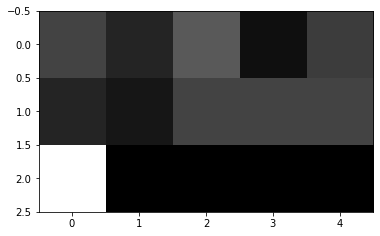

In [28]:
plt.imshow(training_data_primary[0],cmap="gray")

In [30]:
training_data = training_data / 255
validation_data = validation_data / 255

In [31]:
training_data[0]

array([[0.03529412, 0.01960784, 0.04705882, 0.00784314, 0.03137255,
        0.01960784, 0.01176471, 0.03529412, 0.03529412, 0.03529412,
        0.13333333, 0.        , 0.        , 0.        , 0.        ]])

MODELING

In [32]:
model = Sequential()
model.add(Dense(units = 70, activation='relu', input_shape=(15,)))
model.add(Dense(units = 70, activation='relu'))
model.add(Dense(units = 70, activation='relu'))
model.add(Dense(units = 5, activation='softmax', use_bias=False))

In [33]:
optimizer = optimizers.SGD(lr=0.01)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
x_train = np.array(training_data).reshape(10000,15)
y_train = np.array(train_y[0])
x_test = np.array(validation_data).reshape(200,15)
y_test = np.array(test_y[0])

In [35]:
history = model.fit(
    x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test)
)

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.2712 - val_loss: nan - val_accuracy: 0.8000
Epoch 2/10
313/313 [==============================] - 0s 697us/step - loss: nan - accuracy: 0.8065 - val_loss: nan - val_accuracy: 0.8000
Epoch 3/10
313/313 [==============================] - 0s 667us/step - loss: nan - accuracy: 0.8065 - val_loss: nan - val_accuracy: 0.8000
Epoch 4/10
313/313 [==============================] - 0s 694us/step - loss: nan - accuracy: 0.8077 - val_loss: nan - val_accuracy: 0.8000
Epoch 5/10
313/313 [==============================] - 0s 758us/step - loss: nan - accuracy: 0.8049 - val_loss: nan - val_accuracy: 0.8000
Epoch 6/10
313/313 [==============================] - 0s 808us/step - loss: nan - accuracy: 0.8093 - val_loss: nan - val_accuracy: 0.8000
Epoch 7/10
313/313 [==============================] - 0s 767us/step - loss: nan - accuracy: 0.8062 - val_loss: nan - val_accuracy: 0.8000
Epoch 8/10
313/313 [================

MULTI-DIMENTIONAL KNAPSACK

In [36]:
import cplex
import docplex
from docplex.mp.model import Model
import MKP_populate_function as rdmkp

DATA GENERATION

In [44]:
def populating_x_y(files,files_dict,folder):
#-LENGTH OF "A" must match the number of contraints-#
#10 CONSTRAINTS#
    inputs = []
    outputs = []
    for file in files:
        f = open(file, "r")
        s = f.read()
        arr = s.split()
        f.close()

        #-------------------------------------------------------------------------------#
        start = 4
        end = 9
        for count in range(files_dict[file]):
            instance = folder+"/mkp_x_"+str(count)+".dat"
            c = arr[start:end]
            A = [[],[],[],[],[],[],[],[],[],[]]
            l = 103 + 5*count
            j = l
            for i in range(5):
                for k in range(10):
                    A[k].append(arr[j])
                    j += 100
                l += 1
                j = l
            A = np.array(A,dtype='float64')

            obj_arr = []

            for obj in range(10):
                obj_arr.append(np.uint64(arr[len(arr)-10+obj]))
            obj_arr = np.round(np.array(obj_arr)/files_dict[file])
            obj_arr = np.array(obj_arr, dtype="uint64")

        #-------------------------------------------------------------------------------#
            with open(instance, "a") as myfile:
                myfile.truncate(0)
                myfile.write("5 10 0"+"\n")

                for i in range(len(c)):
                    myfile.write(c[i]+" ")
                myfile.write("\n")

                for constraint in range(len(A)):
                    for item in range(len(A[constraint])):
                        myfile.write(str(A[constraint][item])+" ")
                    myfile.write("\n")

                for obj in range(len(obj_arr)):
                    myfile.write(str(obj_arr[obj])+" ")

        #-------------------------------------------------------------------------------#
            c, A, b = rdmkp.MKPpopulate(instance)
            c = np.array(c,dtype="float64")
            nCols, nRows = range(len(c)), range(len(b))
            mkp = Model('MKP')
            x = mkp.binary_var_list(nCols, lb = 0, ub = 1, name = 'x')
            constraints = mkp.add_constraints(sum(A[i][j] * x[j] for j in nCols) <= b[i] for i in nRows)
            profit = mkp.sum(c[j] * x[j] for j in nCols)
            mkp.add_kpi(profit, 'profit')
            obj = mkp.maximize(profit)
            mkp.solve()

        #-------------------------------------------------------------------------------#
            matrix = []
            for count in range(5):
                p = c[count]
                arr_2 = [p]
                for constraint in range(len(A)):
                    arr_2.append(A[constraint][count])
                matrix.append(arr_2)
            capacities = np.matrix(b,dtype='float64').T
            matrix = np.matrix(matrix).T
            matrix = np.pad(matrix, [(0, max((capacities.shape[0] - matrix.shape[0]),0) ), (0,0)])
            capacities = np.pad(capacities, [(0, max((matrix.shape[0] - capacities.shape[0]),0) ), (0,0)])
            matrix = np.concatenate((matrix,capacities), axis = 1)

        #-------------------------------------------------------------------------------#
            solution = []
            for i in range(len(x)):
                solution.append(x[i].solution_value)
            solution = np.array(solution)

        #-------------------------------------------------------------------------------#
            inputs.append(matrix)
            outputs.append(solution)

            start += 5
            end += 5

        #-------------------------------------------------------------------------------#
    return np.array(inputs, dtype='uint64'), np.array(outputs, dtype='uint64')

In [45]:
train_files = ["mkpInstances/chubeas/OR10x250/OR10x250.dat","mkpInstances/chubeas/OR10x500/OR10x500.dat"]
train_files_dict = {
              "mkpInstances/chubeas/OR10x250/OR10x250.dat": 50,
              "mkpInstances/chubeas/OR10x500/OR10x500.dat": 100,
             }
test_files = ["mkpInstances/chubeas/OR10x100/OR10x100.dat"]
test_files_dict = {
              "mkpInstances/chubeas/OR10x100/OR10x100.dat": 20
             }

In [46]:
#populating train data
x_train , y_train = populating_x_y(train_files,train_files_dict,"mkp_train")
#populating test data
x_test , y_test = populating_x_y(test_files,test_files_dict,"mkp_test")


This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance 

This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance 

This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance is not indicated
This instance has 5 variables and 10 constraints
Best integer objective value for this instance 

MODELING

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
model = Sequential()
model.add(Dense(units=70, activation='relu', input_shape=(66,)))
model.add(Dense(units = 70, activation='relu'))
model.add(Dense(units = 70, activation='relu'))
model.add(Dense(units = 70, activation='relu'))
model.add(Dense(units = 70, activation='relu'))
model.add(Dense(units = 70, activation='relu'))

model.add(Dense(units = 5, activation='softmax'))

In [52]:
optimizer = optimizers.SGD(lr=0.01)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['binary_accuracy'])

In [53]:
np.shape(x_train)

(150, 11, 6)

In [54]:
x_train = np.array(x_train).reshape(150,66)
x_test = np.array(x_test).reshape(20,66)

In [55]:
history = model.fit(
    x_train, y_train, epochs=66, verbose=1, validation_data=(x_test, y_test)
)

Epoch 1/66
5/5 [==============================] - 1s 51ms/step - loss: nan - binary_accuracy: 0.5232 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 2/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5839 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 3/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5822 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 4/66
5/5 [==============================] - 0s 8ms/step - loss: nan - binary_accuracy: 0.5842 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 5/66
5/5 [==============================] - 0s 8ms/step - loss: nan - binary_accuracy: 0.5868 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 6/66
5/5 [==============================] - 0s 8ms/step - loss: nan - binary_accuracy: 0.5847 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 7/66
5/5 [==============================] - 0s 8ms/step - loss: nan - binary_accuracy: 0.5835 - val_loss: nan - val_b

Epoch 57/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5847 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 58/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5829 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 59/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5841 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 60/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5858 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 61/66
5/5 [==============================] - 0s 8ms/step - loss: nan - binary_accuracy: 0.5897 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 62/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5802 - val_loss: nan - val_binary_accuracy: 0.5700
Epoch 63/66
5/5 [==============================] - 0s 9ms/step - loss: nan - binary_accuracy: 0.5858 - val_loss: nan -

*REFERENCES:<br><br>
-SIMPLE NEURAL KNAPSACK DATA GENERATION:<br> https://github.com/shshemi/NeuralKnapsack <br><br>
-MKP DATA GENERATION :<br> https://towardsdatascience.com/the-binary-multidimensional-knapsack-problem-mkp-2559745f5fde
                     <br>https://github.com/AghaMS/Multidimensional_Knapsack_Problem_Modelling

In [48]:
x_train[0]

array([[ 612,  582,  610,  495,  573, 1839],
       [ 716,  910,  764, 1133,  876, 1906],
       [ 747, 1145,  797,  761,  705, 1857],
       [ 207,  768,  199,  505,   76, 1845],
       [ 583,  142,   52,  394,  223, 1840],
       [ 422,  396,  538,  638,  984, 1738],
       [ 395,  236,  634,  733,  193, 2029],
       [ 570,  101,  227,  556,  834, 1969],
       [ 286,  685,  831,  503,  578, 1823],
       [ 312,  218,  643,  971,  421, 1915],
       [ 909,  239,  481,  430,  589,    0]], dtype=uint64)

In [50]:
y_train[0]

array([1, 0, 1, 0, 0], dtype=uint64)